### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
plt.style.use('ggplot')

# set some defaults for plotting
COLOR_FEMALE = cm.get_cmap("RdBu")(220) # set blue for female
COLOR_MALE = cm.get_cmap("RdBu")(35) # set red for male
TITLE_SIZE = 22
TITLE_PADDING = 10

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [12, 5],
   }
plt.rcParams.update(params)

import seaborn as sns

import pandas as pd
pd.options.display.max_rows = 500

import numpy as np
np.random.seed(42)

import copy
import os
import sys
import glob
from shutil import copyfile
import time
from tabulate import tabulate
from tqdm.notebook import tqdm

import IPython.display as ipd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

from joblib import dump, load

import librosa

import pydub
from pydub import AudioSegment, effects

from pyannote.audio import Inference
from pyannote.audio import Pipeline as pyannote_Pipeline

import torch

---
# How much do men talk more in podcasts than women do?
### Assessing the share of male and female voices in German / Swissgerman audio media with machine learning

- This notebook makes it easy to **automatically assess the voice share of men and women in batches of MP3 audio files.** 
- It is build for **analysis of podcast media**. 
- This tool is derived from [this project](https://github.com/rnckp/EPFL-Capstone-Project). For the full context of the problem space have a look at [this notebook](https://github.com/rnckp/EPFL-Capstone-Project/blob/main/01_project_overview.ipynb).
- This tool is **meant to facilitate analysis of gender imbalances in audio media** and **to reduce time consuming manual tracking** for media companies and producers.
- Processing time on a local machine (Mac Mini M1) is around 1:10. So **10 hours of podcast episodes take roughly 1 hour of compute**. Analyzing for example the TOP 50 news podcasts in the German iTunes store (20 last epsiodes each, around 500hrs total playing time) takes roughly 50 hours. Retrieving the audio data from a fast SSD drive speeds up processing.

### How does it work?
- I use a **subset of the German CommonVoice data set** (where the speaker's biological sex is labeled) as well as **45k podcast audio samples (German/Swissgerman) that I selected and labeled myself** (with the help of unsupervised/semisupervised methods like KMeans, UMAP etc.).
- I have **gender balanced both data sets to avoid bias toward one biological sex** as much as possible. Interestingly the CommonVoice data itself is [heavily gender imbalanced](https://github.com/rnckp/EPFL-Capstone-Project/blob/main/02_eda.ipynb). 
- I **filtered the available data towards as much speaker variety as possible**. This significantly has helped to train a model that generalizes better toward unknown speakers.
- From all audio samples I extracted as features: [MFCCs](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html), [Chromagram](https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html) and [Contrast](https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html) with librosa and [voice embeddings with pyannote](https://github.com/pyannote/pyannote-audio/tree/develop).
- I tried various classifiers on the data and exhaustively gridsearched optimal hyperparameters. A Support Vector Machine classifier yielded the best results (KNN coming in as second best with ~1% less accuracy).
- The SVC achieves a **crossvalidated accuracy of +99%** (evaluated on 10 validation folds of the 45k ground truth podcast samples). The trained model is available in the repository and simply can be loaded and used.
- In addition to the gender classification I added a **voice activity detection to remove sections without human utterances**. 
- The **code allows for easy batch processing of many thousand files**. See this article for which I used this code to analyze around 2k epsiodes.
- **The model will work with high accuracy on German / Swissgerman language**. Prediction proved to be quite language agnostic. Accuracy will decrease though.

### Helper functions for file processing and feature extraction

In [2]:
SAMPLE_RATE        = 48_000
MFCC_MIN_FREQUENCY = 60
MFCC_MAX_FREQUENCY = 8_000
MFCC_BANDS         = 80

# instantiate pyannote voice embedding
inference = Inference("pyannote/embedding", window="whole")

# instantiate pyannote voice activity detection
MODEL = "hbredin/VoiceActivityDetection-PyanNet-DIHARD"
vad_pipeline = pyannote_Pipeline.from_pretrained(MODEL, device="cuda")

# convert pydub audio file to numpy arraay
def pydub_to_np(audio):
    return np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels)).T

# detect and remove leading and trailing silence
def detect_leading_silence(audio, silence_threshold=-50.0, chunk_size=10):
    trim_ms = 0 # ms
    assert chunk_size > 0 # to avoid infinite loop
    while audio[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(audio):
        trim_ms += chunk_size
    return trim_ms

# convert pydub audio file to pytorch tensor which is needed for pyannote
def get_tensor_from_audiofile(audio_file):
    channel_count = audio_file.channels
    if channel_count==1:
        samples = audio_file.get_array_of_samples()
        wv = np.array(samples).astype(np.float32).reshape(-1, len(samples))
        wv /= np.iinfo(samples.typecode).max
        wv_tensor = torch.tensor(wv)
    elif channel_count==2:
        channels = audio_file.split_to_mono()
        samples = [s.get_array_of_samples() for s in channels]
        wv = np.array(samples).astype(np.float32)
        wv = wv.mean(axis=0)
        wv = wv.reshape(-1, len(wv))
        wv /= np.iinfo(samples[0].typecode).max
        wv_tensor = torch.tensor(wv)
    return wv_tensor

# load and preprocess audio file, extract features with librosa and pyannote
def get_features(file, secs_to_process=2):
    # create empty array to return in case processing fails
    empty_ = np.empty(611,)
    empty_[:] = np.nan 
    
    try:
        audio_file = AudioSegment.from_file(file)
    except Exception as e:
        print(e)
        print(f"{file} can't be loaded")
        return empty_, False  
        
    sample_rate = audio_file.frame_rate

    # normalize audio levels
    try:
        audio_file = effects.normalize(audio_file)  
    except Exception as e:
        print(f"{file} can't be normalized")
        return empty_, False  
    
    # remove silence at beginning and end
    start_trim = detect_leading_silence(audio_file)
    end_trim = detect_leading_silence(audio_file.reverse())
    audio_duration = len(audio_file) 
    audio_file = audio_file[start_trim:audio_duration-end_trim]
    
    if audio_file.duration_seconds > secs_to_process:
        ms_to_process = secs_to_process*1000
        center_of_audio = len(audio_file)/2 
        start_extract = center_of_audio - ms_to_process/2 
        end_extract = start_extract + ms_to_process
        audio_file = audio_file[start_extract:end_extract]
        
    waveform = pydub_to_np(audio_file)
       
    if waveform.ndim == 2: # check if file is stereo 
        waveform = waveform.mean(axis=0) # if stereo merge channels by averaging

    if len(waveform)>0:
        # extract MFCCs
        mfcc_ = np.mean(librosa.feature.mfcc(y=waveform, 
                                             sr=sample_rate, 
                                             n_mfcc=MFCC_BANDS, 
                                             fmin=MFCC_MIN_FREQUENCY,
                                             fmax=MFCC_MAX_FREQUENCY,
                                            ), axis=1) 

        # extract chromagram and contrast
        stft_ = np.abs(librosa.stft(waveform))
        chroma_ = np.mean(librosa.feature.chroma_stft(S=stft_, sr=sample_rate).T, axis=0)
        contrast_ = np.mean(librosa.feature.spectral_contrast(S=stft_, sr=sample_rate).T, axis=0)
        
        # return empty if audio is less than 0.5 seconds after removing silence at beginning and end
        # embedding doesn't work on very short audio fragments
        if audio_file.duration_seconds < 0.5:
            return empty_, False
        
        # get embedding from pyannote
        waveform_tensor = get_tensor_from_audiofile(audio_file)
        embedding_ = inference({"waveform": waveform_tensor, "sample_rate":sample_rate})
        
        # detect voice activity
        vad = vad_pipeline({"waveform": waveform_tensor, "sample_rate":sample_rate})
        voice_activity = False
        
        if len(vad)>0:
            if vad.chart()[0][1] > 0.7: # utterance has to be longer than 0.7 secs
                voice_activity = True
        
        return np.hstack([mfcc_, chroma_, contrast_, embedding_]), voice_activity
                         
    else:
        return empty_, False

# process list of filenames and extract features from each file    
def process_audio_files(file_paths, secs_to_process=2):
    features = []
    vads = []
    for file_path in tqdm(file_paths):
        feats, voice_activity = get_features(file_path, secs_to_process=secs_to_process)
        features.append(feats)
        vads.append(voice_activity)
    features = pd.DataFrame(features)
    vads = pd.DataFrame(vads)
    return features, vads

### Load pretrained Support Vector machine model

In [3]:
pipe = load('SVC_model.joblib') 
display(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('PCA', PCA(n_components=128),
                                                  [99, 100, 101, 102, 103, 104,
                                                   105, 106, 107, 108, 109, 110,
                                                   111, 112, 113, 114, 115, 116,
                                                   117, 118, 119, 120, 121, 122,
                                                   123, 124, 125, 126, 127, 128, ...])])),
                ('svc', SVC(C=5, probability=True))])

### Main function for file loading, preprocessing, feature extraction and prediction

In [18]:
CHUNK_LENGTH = 2
SECS_TO_PROCESS = 2

def analyze_podcast(episode_name, 
                    episode_folder, 
                    chunks_to_process=-1, 
                    copy_chunks=False):

    start = int(time.time())
    
    # create folder for intermediate segment files
    _ = !mkdir "{episode_folder}"/_chunks

    # cut podcast episode in 2 seconds chunks
    _ = !ffmpeg -i "{episode_folder}"/"{episode_name}".mp3 -map 0 -f segment -segment_time $CHUNK_LENGTH -c copy -vn "{episode_folder}"/_chunks/"{episode_name}"_%04d.mp3

    frames = []
    
    # get file list of all chunks
    podcast_seqments = glob.glob(f"{episode_folder}/_chunks/*")
    podcast_seqments = sorted(podcast_seqments)[:chunks_to_process] # default is to leave out the last chunk which likely is shorter than 2 seconds
    pod_meta = pd.DataFrame(podcast_seqments, columns=["file_path"])
    
    # extract features for all chunks, detect voice activity and classify speaker's biological sex
    pod_feat, pod_vad = process_audio_files(pod_meta.file_path, secs_to_process=SECS_TO_PROCESS)

    print(f"Episode is {len(pod_feat)*SECS_TO_PROCESS/60:.0f} minutes long.")
    pod_feat.dropna(inplace=True)
    print(f"For {len(pod_meta) - len(pod_feat)} segments features can't be computed.")

    pod_preds = pipe.predict(pod_feat)
    pod_preds = pd.DataFrame(pod_preds, index=pod_feat.index)

    pod_preds_labels = np.where(pod_preds=="male", True, False)
    pod_preds_labels = pd.DataFrame(pod_preds_labels, index=pod_feat.index)

    pod_proba = pipe.predict_proba(pod_feat)
    pod_proba = pd.DataFrame(pod_proba, index=pod_feat.index)

    pod_meta["predicted"] = pod_preds
    pod_meta["predicted_proba"] = pod_proba.max(axis=1)
    pod_meta["voice_activity"] = pod_vad

    pod_meta.predicted.fillna("not_computed", inplace=True)
    pod_meta.loc[pod_meta.voice_activity==False, "predicted"] = "no_voice"
    no_voice_cnt = pod_meta[pod_meta.voice_activity==False].shape[0]

    # set confidence treshold for low probability predictions
    # discarding these from the final calculation helps to improve accuracy (difference is minor though)
    # for SVC 0.95 is a sensible default
    low_threshold = 0.95
    low_proba = pod_meta[(pod_meta.predicted_proba <= low_threshold) & 
                         (pod_meta.voice_activity==True)].index
    low_proba_cnt = len(low_proba)
    print(f"{low_proba_cnt} ({100/len(pod_meta)*low_proba_cnt:.2f}%) predictions with confidence below {low_threshold}.\n")

    pod_low_proba = pod_meta.iloc[low_proba]
    pod_high_proba = pod_meta.drop(pod_low_proba.index).copy()
    
    pod_low_proba = pod_low_proba[pod_low_proba.voice_activity==True]
    pod_high_proba = pod_high_proba[pod_high_proba.voice_activity==True]
    
    if copy_chunks==True:
        # create directories to save predicted chunks to
        _ = !mkdir "{episode_folder}"/_low_confidence_male
        _ = !mkdir "{episode_folder}"/_low_confidence_female
        _ = !mkdir "{episode_folder}"/_predicted_male
        _ = !mkdir "{episode_folder}"/_predicted_female
    
        # copy all predicted chunks into separate folders – this allows for easy inspection and error correction
        for prediction in ["male", "female"]:
            for filename in pod_low_proba[pod_low_proba.predicted==prediction].file_path.values:
                file = filename.split("_chunks/")[1]
                destination = f"{episode_folder}/_low_confidence_{prediction}/{file}"
                copyfile(filename, destination)
            for filename in pod_high_proba[pod_high_proba.predicted==prediction].file_path.values:
                file = filename.split("_chunks/")[1]
                destination = f"{episode_folder}/_predicted_{prediction}/{file}"
                copyfile(filename, destination)

    map_labels = dict(zip(["male", "female", "not_computed", "no_voice"], range(0,4)))
    labels_mapped = pod_meta.predicted.map(map_labels).to_list()

    colors = [COLOR_MALE, COLOR_FEMALE]
    unique_labels = pod_meta.predicted.unique()

    if "no_voice" in unique_labels and "not_computed" in unique_labels:
        colors = [COLOR_MALE, COLOR_FEMALE, "black", "white"]
    elif "no_voice" in unique_labels:
        colors = [COLOR_MALE, COLOR_FEMALE, "white"]  
    elif "not_computed" in unique_labels:
        colors = [COLOR_MALE, COLOR_FEMALE, "black"]
        
    # plot colored timeline of podcast episode
    plt.figure(figsize=(12,0.7))
    sns.heatmap(pd.DataFrame(labels_mapped).T, cbar=False, center=True, cmap=ListedColormap(colors))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()
          
    label_ratio = pod_high_proba.predicted.value_counts(normalize=True)
    print(tabulate(label_ratio.to_frame(), floatfmt=".2f"))
    
    male_all = pod_meta[pod_meta.predicted=="male"].predicted.count()
    female_all = pod_meta[pod_meta.predicted=="female"].predicted.count()

    male_high_proba = pod_high_proba[pod_high_proba.predicted=="male"].predicted.count()
    female_high_proba = pod_high_proba[pod_high_proba.predicted=="female"].predicted.count()    
    
    end = time.time()
    processing_time = end-start
    episode_length = len(podcast_seqments)*SECS_TO_PROCESS
    
    tmp = pd.DataFrame([episode_name, episode_length, processing_time, labels_mapped,   
                        male_all, female_all, male_high_proba, female_high_proba, 
                        low_proba_cnt, no_voice_cnt])
    tmp = pd.concat([tmp, label_ratio]).T
    
    # clean up chunk folder
    _ = !rm "{episode_folder}"/_chunks/*
    _ = !rmdir "{episode_folder}"/_chunks
    
    return tmp

### Set project directory and start processing

- To batch process files **you need to setup a base directory which contains one subfolder per podcast show**. 
- **In each of these podcast show directories simply put as many audio/episode files as you want to process.** 
- Alternatively just create one subfolder and copy all files that you want to analyze into this single folder.
- The file format has to be MP3 (but can be easily changed in the code to other formats as well).

--------------------------------------------------------------------------------
apokalypse_filterkaf_0001


  0%|          | 0/100 [00:00<?, ?it/s]

Episode is 3 minutes long.
For 0 segments features can't be computed.
5 (5.00%) predictions with confidence below 0.95.



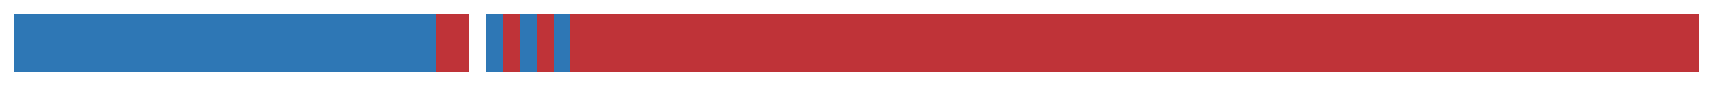

------  ----
male    0.72
female  0.28
------  ----
--------------------------------------------------------------------------------
kekul_s_corona_kompa_0001


  0%|          | 0/100 [00:00<?, ?it/s]

Episode is 3 minutes long.
For 0 segments features can't be computed.
1 (1.00%) predictions with confidence below 0.95.



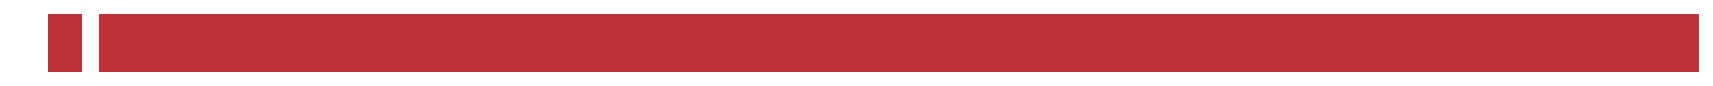

----  ----
male  1.00
----  ----
--------------------------------------------------------------------------------
deutschlandfunk_der__0001


  0%|          | 0/100 [00:00<?, ?it/s]

Episode is 3 minutes long.
For 0 segments features can't be computed.
4 (4.00%) predictions with confidence below 0.95.



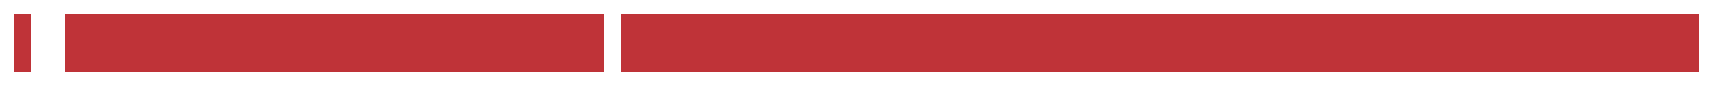

----  ----
male  1.00
----  ----
CPU times: user 2min 52s, sys: 1min 33s, total: 4min 25s
Wall time: 1min 21s


In [28]:
%%time
# path to your project directory
PROJECT_DIRECTORY = "your_project_folder/"
    
episode_folders = [f.path for f in os.scandir(PROJECT_DIRECTORY) if f.is_dir()]
episode_folders = sorted(episode_folders)

for episode_folder in episode_folders:
    episodes = glob.glob(f"{episode_folder}/*.mp3")
    episodes = list(sorted(episodes))
    
    results = []
    for episode in episodes:
        episode = episode.split("/")[-1].replace(".mp3", "")
        print("-"*80)
        print(episode)
        results.append(analyze_podcast(episode, episode_folder, 
                                       # 1 chunk == 2 seconds, e.g. set to chunks_to_process=30 if you want to process 60secs/1min
                                       # set chunks_to_process=-1 to process whole episodes
                                       chunks_to_process=100,
                                       # set to True if you want to examine predicted audio segments
                                       # code will copy predicted chunks to separate subfolders in podcast subfolder
                                       copy_chunks=False
                                      ))

    df = pd.concat(results).reset_index(drop=True)
    cols = ["file_name", "length", "processing_time", "labels",   
            "male_all", "female_all", "male_confident", "female_confident",
           "low_confidence", "no_voice"]
    cols.extend(df.columns[10:])
    df.columns = cols
    
    # save result per podcast per folder into folder itself
    df.to_csv(f"{episode_folder}/{episode_folder.split('/')[-1]}_results.csv", index=False)
    
    df.head()

### Load results and analyze

In [29]:
results = []
for episode_folder in episode_folders:
    tmp = glob.glob(f"{episode_folder}/*.csv")
    if len(tmp)>0:
        tmp = pd.read_csv(tmp[0])
        tmp["folder_name"] = episode_folder.split("/")[-1]
        results.append(tmp)

df = pd.concat(results).reset_index(drop=True)

# drop full list of predicted labels since these likely won't be needed for analysis
df.drop("labels", axis=1, inplace=True)

# reorder columns
cols = ['folder_name', 'file_name', 'length', 'processing_time', 'male_all', 'female_all',
       'male_confident', 'female_confident', 'low_confidence', 'no_voice', 'female',
       'male']
df = df[cols]

# NaNs in feature female/male actually mean 0, so we fill 0 where NaNs are present
df.male.fillna(0, inplace=True)
df.female.fillna(0, inplace=True)

# sanity check for any remaining NaN values
assert df.isna().any().sum() == 0

# sanity check for duplicated episode entries
assert df.duplicated().sum() == 0

df.head(10)

,folder_name,file_name,length,processing_time,male_all,female_all,male_confident,female_confident,low_confidence,no_voice,female,male
0,Apokalypse und Filterkaffee,apokalypse_filterkaf_0001,200,27.479272,71,28,68,26,5,1,0.276596,0.723404
1,Corona Kompass,kekul_s_corona_kompa_0001,200,27.584394,97,0,96,0,1,3,0.000000,1.000000
2,Deutschlandfunk Der Tag,deutschlandfunk_der__0001,200,27.111036,97,0,93,0,4,3,0.000000,1.000000


In [30]:
print(f"Analyzed {len(df)} epsiodes from {df.folder_name.nunique()} unique podcast folders.\n")

# every sample accounts for 2 seconds
male_total = df.male_confident.sum()*2/3600
female_total = df.female_confident.sum()*2/3600
low_proba = df.low_confidence.sum()*2/3600
no_voice = df.no_voice.sum()*2/3600

total = male_total + female_total + low_proba + no_voice
total_voice = male_total + female_total

male_perc = 100/total*male_total
male_voice_perc = 100/total_voice*male_total 

female_perc = 100/total*female_total
female_voice_perc = 100/total_voice*female_total 

low_proba_perc = 100/total*low_proba
no_voice_perc = 100/total*no_voice

print(f"Total playing time:    {df.length.sum()/3600:05.1f} hrs ({total:.1f} in segments)")
print(f"Total processing time: {df.processing_time.sum()/3600:05.1f} hrs")
print("")
print(f"Total male voices:     {male_total:05.1f} hrs | {male_perc:.1f}% of total, {male_voice_perc:.1f}% of voice")
print(f"Total female voices:   {female_total:05.1f} hrs | {female_perc:.1f}% of total, {female_voice_perc:.1f}% of voice")
print(f"Low probability:       {low_proba:05.1f} hrs | {low_proba_perc:.1f}%")
print(f"No voice activity:     {no_voice:05.1f} hrs | {no_voice_perc:.1f}%")

Analyzed 3 epsiodes from 3 unique podcast folders.

Total playing time:    000.2 hrs (0.2 in segments)
Total processing time: 000.0 hrs

Total male voices:     000.1 hrs | 85.7% of total, 90.8% of voice
Total female voices:   000.0 hrs | 8.7% of total, 9.2% of voice
Low probability:       000.0 hrs | 3.3%
No voice activity:     000.0 hrs | 2.3%


In [31]:
cols = ['male_all', 'female_all', 'male_confident', 'female_confident']
tmp = df.groupby("folder_name")[cols].sum()
tmp["male_perc_all"] = 100/(tmp.female_all+tmp.male_all)*tmp.male_all
tmp["male_perc_confident"] = 100/(tmp.female_confident+tmp.male_confident)*tmp.male_confident
tmp["confidence_diff"] = np.abs(tmp.male_perc_all - tmp.male_perc_confident)
print(f"There is a {tmp.confidence_diff.mean():.1f}% difference between confident predictions vs. all predictions.")

There is a 0.2% difference between confident predictions vs. all predictions.


In [32]:
df["male_perc_confident"] = 100/(df.female_confident+df.male_confident)*df.male_confident
df_sum = df.groupby("folder_name").male_perc_confident.describe()[["mean", "50%"]]

with pd.option_context('display.float_format', '{:,.1f}'.format):
    display(df_sum.sort_values("50%", ascending=False))

,mean,50%
folder_name,,
Corona Kompass,100.0,100.0
Deutschlandfunk Der Tag,100.0,100.0
Apokalypse und Filterkaffee,72.3,72.3


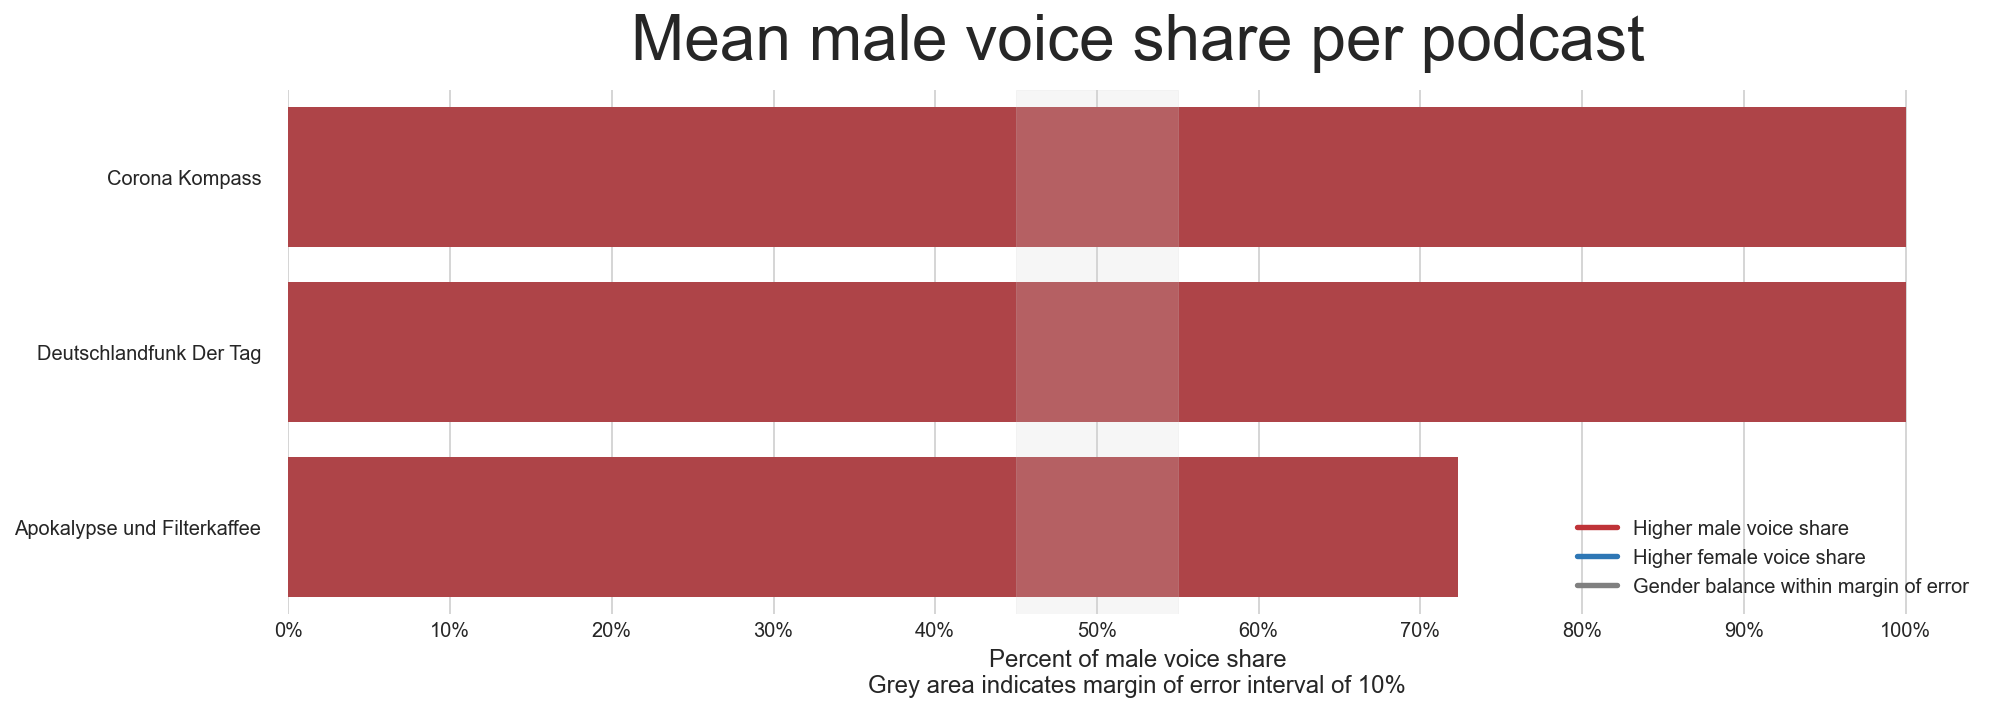

In [33]:
plt.style.use("seaborn-whitegrid")

df_sum.sort_values("mean", ascending=False, inplace=True)

colors = []
error_interval = 10
error_lower = 50-error_interval/2
error_upper = 50+error_interval/2

for mean_ in df_sum[["mean"]].values:
    if mean_ > error_upper:
        colors.append(COLOR_MALE)
    elif mean_ <=error_lower:
        colors.append(COLOR_FEMALE)
    else:
        colors.append("grey")
        
plt.figure(figsize=(14,5))
ax = sns.barplot(data=df_sum, x="mean", y=df_sum.index, palette=colors, capsize=10)
plt.title("Mean male voice share per podcast", size=TITLE_SIZE+10, pad=TITLE_PADDING+5)
plt.xlim(0, 105)
rng = range(0, 110, 10)
plt.xticks(ticks=rng, labels=[str(x)+"%" for x in rng])
plt.yticks(size=12)
plt.axvspan(error_lower, error_upper, alpha=0.2, color='lightgrey')
plt.xlabel(f"Percent of male voice share\nGrey area indicates margin of error interval of {error_interval}%")
plt.ylabel("")

plt.legend(["Higher male voice share", "Higher female voice share", "Gender balance within margin of error"], loc="lower right")
leg = ax.get_legend()
leg.legendHandles[0].set_color(COLOR_MALE)
leg.legendHandles[1].set_color(COLOR_FEMALE)
leg.legendHandles[2].set_color("grey")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 0))

plt.tight_layout()
# plt.savefig("result.png")
plt.show()